In [ ]:
!pip install transformers
!pip install datasets
!pip install pytorch_lightning

# Standard Vision Transformer

Steps -
1. Preprocessing
2. Training
3. Testing and Validation.
4. Metrics

## Preprocessing Steps:

1. Creating the Hugging Face Dataset from the custom Created Mel Spectograms.
2. Spliting data into Train, Test and Validation
3. Creating the pixel values and Labels

### Step 1 and 2:
1. Creating the Hugging Face Dataset from the custom Created Mel Spectograms.
2. Spliting data into Train, Test and Validation


In [1]:
from datasets import load_dataset

train_ds = load_dataset("imagefolder", data_dir="audio_transformer/data/train", split="train")


# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.3)
train_val_ds = splits['train']
test_ds = splits['test']

splits = train_val_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


print(len(train_ds),len(test_ds),len(val_ds))

Resolving data files:   0%|          | 0/8733 [00:00<?, ?it/s]

Using custom data configuration default-056bb73702904399
Reusing dataset image_folder (/home/ubuntu/.cache/huggingface/datasets/image_folder/default-056bb73702904399/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


5500 2620 612


In [2]:
import json

with open('audio_transformer/data/label2id.json') as f:
    label2id = json.load(f)

with open('audio_transformer/data/id2label.json') as f:
    id2label = json.load(f)

id2label = {int(key):value for key,value in id2label.items()}
id2label

{0: 'air_conditioner',
 1: 'car_horn',
 2: 'children_playing',
 3: 'dog_bark',
 4: 'drilling',
 5: 'engine_idling',
 6: 'gun_shot',
 7: 'jackhammer',
 8: 'siren',
 9: 'street_music'}

In [3]:
train_ds

Dataset({
    features: ['image', 'classID', 'class'],
    num_rows: 5500
})

### Step 3:
We will now preprocess the data. The model requires 2 things: `pixel_values` and `labels`. 

We will perform data augmentaton **on-the-fly** using HuggingFace Datasets' `set_transform` method (docs can be found [here](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=set_transform#datasets.Dataset.set_transform)). This method is kind of a lazy `map`: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here. 

In [4]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

In [5]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(feature_extractor.size),
            CenterCrop(feature_extractor.size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [6]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [7]:
train_ds[:2]


{'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7F0B445D4828>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=496x369 at 0x7F0C542CF128>],
 'classID': [0, 7],
 'class': ['air_conditioner', 'jackhammer'],
 'pixel_values': [tensor([[[-0.0745, -0.0902, -0.1216,  ..., -0.0980, -0.0980, -0.0980],
           [-0.0745, -0.0902, -0.1216,  ..., -0.0980, -0.0980, -0.0980],
           [-0.0745, -0.0902, -0.1216,  ..., -0.0980, -0.0980, -0.0980],
           ...,
           [ 0.6392,  0.6314,  0.6235,  ...,  0.5216,  0.5216,  0.5216],
           [ 0.6078,  0.6157,  0.6314,  ...,  0.5216,  0.5216,  0.5216],
           [ 0.6078,  0.6157,  0.6314,  ...,  0.5216,  0.5216,  0.5216]],
  
          [[-0.7412, -0.7490, -0.7569,  ..., -0.7490, -0.7490, -0.7490],
           [-0.7412, -0.7490, -0.7569,  ..., -0.7490, -0.7490, -0.7490],
           [-0.7412, -0.7490, -0.7569,  ..., -0.7490, -0.7490, -0.7490],
           ...,
           [-0.4824, -0.4902, -0.4980,  ..., -0.

In [8]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["classID"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 2
eval_batch_size = 2

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size,num_workers=16)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size,num_workers=16)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size,num_workers=16)



In [9]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([2, 3, 224, 224])
labels torch.Size([2])


In [10]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [11]:
next(iter(val_dataloader))['pixel_values'].shape


torch.Size([2, 3, 224, 224])

## Training:
1. Defining Model
2. Loading the Pretrained Model
3. Actual Training.

## Define the model:

Here we define a `LightningModule`, which is very similar to a regular `nn.Module`, but with some additional functionalities.

The model itself uses a linear layer on top of a pre-trained `ViTModel`. We place a linear layer on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image. We also add dropout for regularization.

A resource that helped me in understanding PyTorch Lightning is the [documentation](https://pytorch-lightning.readthedocs.io/en/latest/index.html) as well as the [tutorial notebooks](https://github.com/PyTorchLightning/pytorch-lightning/tree/master/notebooks).

In [12]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=10,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

## Train the model

Let's first start up Tensorboard (note that PyTorch Lightning logs to Tensorboard by default):

In [13]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [14]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
trainer = Trainer(gpus=0, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: False, used: Fals

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Testing and Validation:

1. Evaluation

## Evaluation:
1. Finally, let's evaluate the model on the test set:


In [27]:
trainer.test()

# trainer.test(ckpt_path='/home/ubuntu/lightning_logs/version_2/checkpoints/epoch=10-step=30249.ckpt')

AttributeError: 'Dataset' object has no attribute '_current_fx_name'

In [25]:
# inputs = feature_extractor(test_ds[0]['image'], return_tensors="pt")

# with torch.no_grad():
#     logits = model(**inputs).logits

# print(model.config.id2label[predicted_label])
# predicted_label = logits.argmax(-1).item()

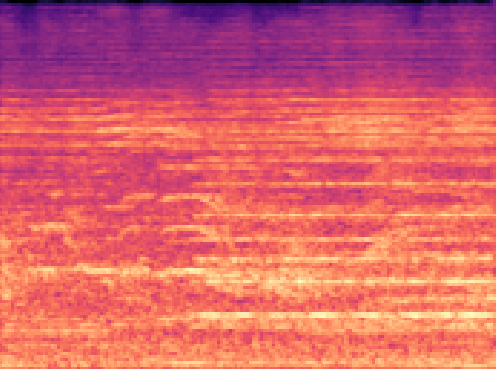

In [18]:
test_ds[0]['image']

In [16]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

AttributeError: 'Dataset' object has no attribute '_current_fx_name'

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [31]:
model_10 = ViTLightningModule.load_from_checkpoint('/home/ubuntu/lightning_logs/version_2/checkpoints/epoch=10-step=30249.ckpt')

trainer_final = Trainer(gpus=0, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer_final.fit(model_10)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: False, used: Fals

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/ubuntu/anaconda3/envs/aws_neuron_pytorch_p36/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [33]:
trainer_final.test()

Restoring states from the checkpoint path at /home/ubuntu/lightning_logs/version_3/checkpoints/epoch=0-step=2749.ckpt
Loaded model weights from checkpoint at /home/ubuntu/lightning_logs/version_3/checkpoints/epoch=0-step=2749.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


[{}]

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/aws_neuron_pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/aws_neuron_pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/aws_neuron_pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/aws_neuron_pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
